In [1]:
from IPython.display import Image

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
from tqdm import tqdm

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000

In [3]:
import re
import pandas as pd


def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

df = pd.read_csv('imdb.tsv', sep='\t')
df.shape

(25000, 3)

In [4]:
from bs4 import BeautifulSoup

texts = []
labels = []

for idx in tqdm(range(df.shape[0])):
    text = BeautifulSoup(df.review[idx], 'lxml')
    texts.append(clean_str(text.get_text()))
    labels.append(df.sentiment[idx])

100%|██████████| 25000/25000 [00:11<00:00, 2160.19it/s]


In [5]:
from keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/opt/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 81501 unique tokens.


In [6]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = np.asarray(labels).reshape(-1,1)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (25000, 1000)
Shape of label tensor: (25000, 1)


In [7]:
print('input_dim', len(word_index) + 1)

input_dim 81502


In [8]:
input_dim = 81502

In [3]:
from sklearn.externals import joblib

In [14]:
joblib.dump((X, y), 'xy')

['xy']

In [4]:
X, y = joblib.load('xy')

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1337, shuffle=True) 

In [10]:
y_train.shape, y_val.shape

((20000, 1), (5000, 1))

# 1 Training FeedForward NN

### 1.1.1 SGD
![img](https://airussian.files.wordpress.com/2012/10/gradient_descent.gif?w=625)

In [11]:
from keras.layers import Dense, Embedding, Flatten
from keras.optimizers import SGD
from keras.models import Sequential

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 8)           652016    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                80010     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________
best loss: 0.6900243305206298


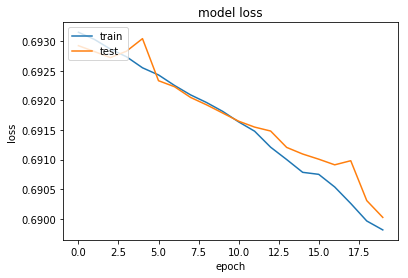

In [13]:
model_sgd = Sequential()
model_sgd.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_sgd.add( Flatten())
model_sgd.add( Dense(10, activation='relu') )
model_sgd.add( Dense(1, activation='sigmoid'))

opt = SGD(lr = 0.01, momentum=0)
model_sgd.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_sgd.summary()

h = model_sgd.fit(X, y, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=False)

print('best loss:', h.history['val_loss'][-1])

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1.1.2 Momentum

$$ v_t = \gamma v_{t-1} - \eta \nabla_{\theta} J(\theta)$$
$$ \theta_t = \theta_{t-1} - v_t $$

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 8)           652016    
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                80010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________
best loss: 0.1662310956954956


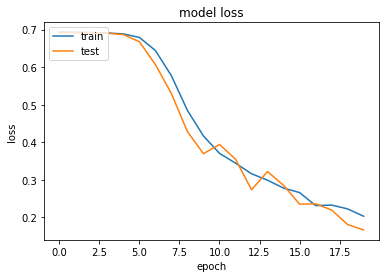

In [14]:
model_mom = Sequential()
model_mom.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_mom.add( Flatten())
model_mom.add( Dense(10, activation='relu') )
model_mom.add( Dense(1, activation='sigmoid'))

opt = SGD(lr = 0.01, momentum=0.9)
model_mom.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_mom.summary()

h = model_mom.fit(X, y, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=False)

print('best loss:', h.history['val_loss'][-1])

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1.1.3 Rmsprob
$$ g_t = \nabla_{\theta} J(\theta) $$
$$  E[g^2]_t = \alpha E[g^2]_{t-1} + (1-\alpha) g^2_t $$
$$  \theta_t = \theta_{t-1} - \frac {\eta} {\sqrt {E[g^2]_t} + \epsilon} g_t $$

In [15]:
from keras.optimizers import RMSprop

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 8)           652016    
_________________________________________________________________
flatten_3 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                80010     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________
best loss: 5.788754373861593e-06


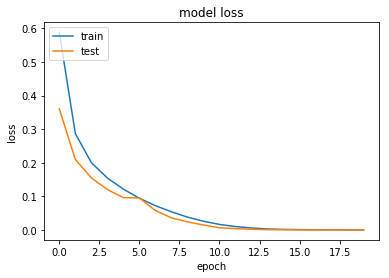

In [16]:
model_rms = Sequential()
model_rms.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_rms.add( Flatten())
model_rms.add( Dense(10, activation='relu') )
model_rms.add( Dense(1, activation='sigmoid'))

opt = RMSprop(lr=0.001, rho=0.9)
model_rms.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_rms.summary()

h = model_rms.fit(X, y, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=False)

print('best loss:', h.history['val_loss'][-1])

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 1.1.4 Adam
$$ g_t = \nabla_{\theta} J(\theta) $$

$$ m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t $$
$$ v_t = \beta_2 v_{t-1} + (1-\beta_2) g^2_t $$
$$ \hat m_t = \frac {m_t} {1 - \beta_1^t} $$
$$ \hat v_t = \frac {v_t} {1 - \beta_2^t}  $$
$$  \theta_t = \theta_{t-1} - \frac {\eta} {\sqrt {\hat v_t} + \epsilon} m_t $$

In [17]:
from keras.optimizers import Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 8)           652016    
_________________________________________________________________
flatten_5 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                80010     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________
best loss: 0.00022732188876252622


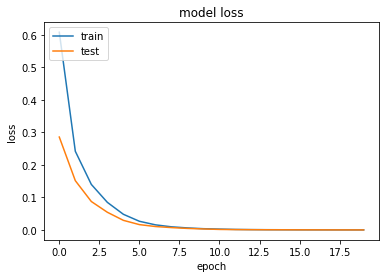

In [19]:
model_adam = Sequential()
model_adam.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_adam.add( Flatten())
model_adam.add( Dense(10, activation='relu') )
model_adam.add( Dense(1, activation='sigmoid'))

opt = Adam()
model_adam.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_adam.summary()

h = model_adam.fit(X, y, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=False)

print('best loss:', h.history['val_loss'][-1])

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Comparison of different optimizers
![img](http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s400/s25RsOr%2B-%2BImgur.gif)

## 1.2 Weight initialization

![img](https://intoli.com/blog/neural-network-initialization/img/relu-output-progression-violinplot.png)

ex: Glorot Weight initialization

for-each input-hidden weight  
    variance = 2.0 / (fan-in +fan-out)  
    stddev = sqrt(variance)  
    weight = gaussian(mean=0.0, stddev)  
end-for  

In [20]:
from keras.initializers import uniform, normal

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer=<keras.ini...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 8)           652016    
_________________________________________________________________
flatten_6 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                80010     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________
best loss: 0.6931380944252015


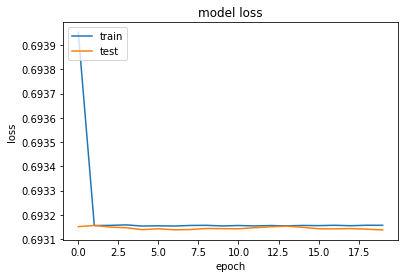

In [21]:
def my_init(shape, name=None):
    return uniform(shape=shape)

model_init1 = Sequential()
model_init1.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_init1.add( Flatten())
model_init1.add( Dense(10, activation='relu', init=uniform(10)) )
model_init1.add( Dense(1, activation='sigmoid'))

opt = SGD()
model_init1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_init1.summary()

h = model_init1.fit(X, y, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=False)

print('best loss:', h.history['val_loss'][-1])

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer=<keras.ini...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 8)           652016    
_________________________________________________________________
flatten_7 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                80010     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________
best loss: 0.6931483043670654


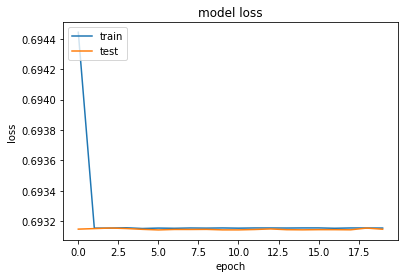

In [22]:
model_init2 = Sequential()
model_init2.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_init2.add( Flatten())
model_init2.add( Dense(10, activation='relu', init=normal(10)) )
model_init2.add( Dense(1, activation='sigmoid'))

opt = SGD()
model_init2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_init2.summary()

h = model_init2.fit(X, y, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=False)

print('best loss:', h.history['val_loss'][-1])

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 1.3 Batch normalization
$\mu = \frac 1 m \sum_{i=1}^m x_i$ - batch mean   
$\sigma^2 = \frac 1 {m-1} \sum_{i=1}^m (x_i - \mu)^2$ - batch variance     
$\hat x_i = \frac {x_i - \mu} {\sigma + \epsilon} $ - normalized   
$ y_i = \gamma \hat x_i + \beta$ - scale and shift  

![img](https://zaffnet.github.io/assets/batchnorm/prepro1.jpeg)

In [23]:
from keras.layers import BatchNormalization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 8)           652016    
_________________________________________________________________
flatten_8 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                80010     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10)                40        
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
__________

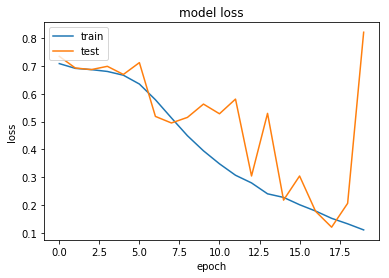

In [24]:
model_bn = Sequential()
model_bn.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_bn.add( Flatten())
model_bn.add( Dense(10, activation='relu') )
model_bn.add( BatchNormalization())
model_bn.add( Dense(10, activation='relu') )
model_bn.add( BatchNormalization())
model_bn.add( Dense(10, activation='relu') )
model_bn.add( Dense(1, activation='sigmoid'))

opt = SGD()
model_bn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_bn.summary()

h = model_bn.fit(X, y, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=False)

print('best loss:', h.history['val_loss'][-1])

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 1.4 Data normalization

# 2 Regularization

## 2.1 L1 L2 weight norm

In [25]:
from keras.regularizers import l2 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 8)           652016    
_________________________________________________________________
flatten_9 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                80010     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________
best loss: 0.6931499807357788


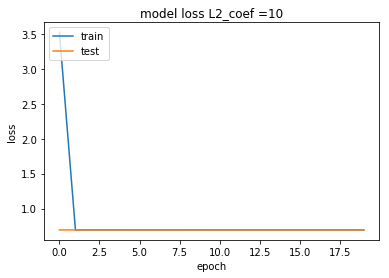

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 8)           652016    
_________________________________________________________________
flatten_10 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                80010     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________


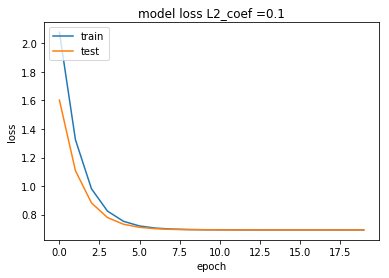

In [26]:
model_reg1 = Sequential()
model_reg1.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_reg1.add( Flatten())
model_reg1.add( Dense(10, activation='relu', kernel_regularizer=l2(10)))
model_reg1.add( Dense(1, activation='sigmoid'))

opt = SGD()
model_reg1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_reg1.summary()

h = model_reg1.fit(X, y, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=False)

print('best loss:', h.history['val_loss'][-1])

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss L2_coef =10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

######################################

model_reg2 = Sequential()
model_reg2.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_reg2.add( Flatten())
model_reg2.add( Dense(10, activation='relu', kernel_regularizer=l2(0.1)))
model_reg2.add( Dense(1, activation='sigmoid'))

opt = SGD()
model_reg2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_reg2.summary()

h = model_reg2.fit(X, y, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=False)

print('best loss:', h.history['val_loss'][-1])

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss L2_coef =0.1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 2.2 Dropout

$p$ - dropout rate  
$ d_i \sim Bernulli(1-p) $  
$ \hat y_i = d_i * activation(w^Tx_i +b) $ - training  
$ \hat y_i = (1-p) * activation(w^Tx_i +b) $ - testing  




![img](https://cdn-images-1.medium.com/max/1600/1*iWQzxhVlvadk6VAJjsgXgg.png)

In [30]:
from keras.layers import Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 1000, 8)           652016    
_________________________________________________________________
flatten_17 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)                80010     
_________________________________________________________________
dense_40 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_41 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 11        
Total params: 732,257
Trainable params: 732,257
Non-trainable params: 0
_________________________________________________________________
best

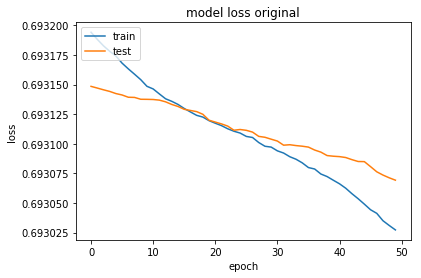

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 1000, 8)           652016    
_________________________________________________________________
flatten_18 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8000)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)                80010     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
__________

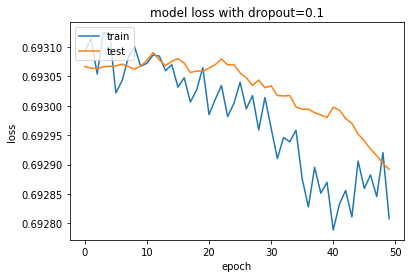

In [35]:
model_drop1 = Sequential()
model_drop1.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_drop1.add( Flatten())
model_drop1.add( Dense(10, activation='relu') )
model_drop1.add( Dense(10, activation='relu') )
model_drop1.add( Dense(10, activation='relu') )
model_drop1.add( Dense(1, activation='sigmoid'))

opt = SGD()
model_drop1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_drop1.summary()

h = model_drop1.fit(X, y, validation_data=(X_val, y_val), batch_size=1024, epochs=50, verbose=False)
print('best loss:', h.history['val_loss'][-1])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss original')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##################################################

model_drop2 = Sequential()
model_drop2.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_drop2.add( Flatten())
model_drop2.add( Dropout(0.1))
model_drop2.add( Dense(10, activation='relu') )
model_drop2.add( Dropout(0.1))
model_drop2.add( Dense(10, activation='relu') )
model_drop2.add( Dropout(0.1))
model_drop2.add( Dense(10, activation='relu') )
model_drop2.add( Dense(1, activation='sigmoid'))

opt = SGD()
model_drop2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_drop2.summary()

h = model_drop2.fit(X, y, validation_data=(X_val, y_val), batch_size=1024, epochs=50, verbose=False)
print('best loss:', h.history['val_loss'][-1])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss with dropout=0.1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 2.3 Early stopping


In [32]:
from keras.callbacks import EarlyStopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 1000, 8)           652016    
_________________________________________________________________
flatten_15 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 10)                80010     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________
best loss: 1.0968151058250441e-07


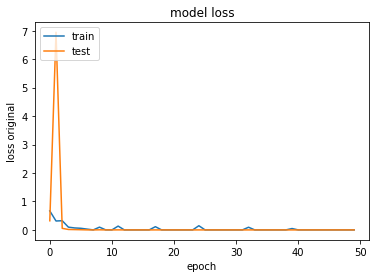

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 1000, 8)           652016    
_________________________________________________________________
flatten_16 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)                80010     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 11        
Total params: 732,037
Trainable params: 732,037
Non-trainable params: 0
_________________________________________________________________
best loss: 0.0009555727705359459


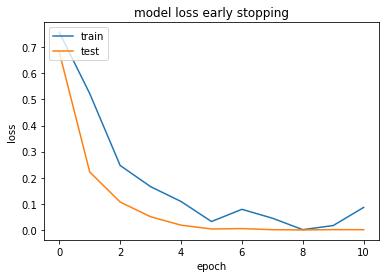

In [33]:
model_early = Sequential()
model_early.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_early.add( Flatten())
model_early.add( Dense(10, activation='relu') )
model_early.add( Dense(1, activation='sigmoid'))

opt = RMSprop(lr=0.01, rho=0.9)
model_early.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_early.summary()

h = model_early.fit(X, y, validation_data=(X_val, y_val), batch_size=512, epochs=50, 
                  verbose=False)                 
print('best loss:', h.history['val_loss'][-1])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss original')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#################################################

model_early2 = Sequential()
model_early2.add( Embedding(input_dim=input_dim, output_dim=8, input_length=MAX_SEQUENCE_LENGTH) )
model_early2.add( Flatten())
model_early2.add( Dense(10, activation='relu') )
model_early2.add( Dense(1, activation='sigmoid'))

opt = RMSprop(lr=0.01, rho=0.9)
model_early2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_early2.summary()

h = model_early2.fit(X, y, validation_data=(X_val, y_val), batch_size=512, epochs=50, 
                  verbose=False,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2, verbose=0)]
                 )
print('best loss:', h.history['val_loss'][-1])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss early stopping')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 3 Convolutional NN for text classification

Formal definition of convolution of functions $f$ and $g$
$$ (f∗g)(t)= \int_0^{\infty} f(\tau)g(t−\tau) d{\tau} $$

![img](http://www.stokastik.in/wp-content/uploads/2016/09/convolution_ilustration.png)

In [8]:
from keras.layers import Embedding
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

In [16]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, 
                    output_dim=100, 
                    input_length=MAX_SEQUENCE_LENGTH))

model.add( Conv1D(64, 5, activation='relu') )
model.add( MaxPooling1D(5) )
model.add( Conv1D(64, 5, activation='relu') )
model.add( MaxPooling1D(5) )
model.add( Conv1D(64, 5, activation='relu') )
model.add( MaxPooling1D(35) )
model.add( Flatten() )
model.add( Dense(64, activation='relu') )
model.add( Dense(1, activation='sigmoid') )

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 100)         8150200   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 996, 64)           32064     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 199, 64)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 195, 64)           20544     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 39, 64)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 35, 64)            20544     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 1, 64)             0         
__________

In [17]:
model.fit(X_imdb, y_imdb, validation_split=0.2, epochs=10, batch_size=128)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 228us/step - loss: 0.5103 - acc: 0.7147 - val_loss: 0.3057 - val_acc: 0.8740
Epoch 2/10
20000/20000 [==============================] - 4s 194us/step - loss: 0.2533 - acc: 0.8981 - val_loss: 0.3895 - val_acc: 0.8380
Epoch 3/10
20000/20000 [==============================] - 4s 192us/step - loss: 0.1698 - acc: 0.9358 - val_loss: 0.3103 - val_acc: 0.8762
Epoch 4/10
20000/20000 [==============================] - 4s 189us/step - loss: 0.1151 - acc: 0.9598 - val_loss: 0.4570 - val_acc: 0.8526
Epoch 5/10
20000/20000 [==============================] - 4s 191us/step - loss: 0.0692 - acc: 0.9769 - val_loss: 0.3812 - val_acc: 0.8832
Epoch 6/10
20000/20000 [==============================] - 4s 189us/step - loss: 0.0383 - acc: 0.9871 - val_loss: 0.8626 - val_acc: 0.8118
Epoch 7/10
20000/20000 [==============================] - 4s 188us/step - loss: 0.0257 - acc: 0.9915 - val_loss: 0.6438 - v

In [18]:
model.save('model_conv')

# 4 Recurrent Neural Networks

## 4.1 Simple RNN

![img](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/06022525/bptt.png)

## 4.2 LSTM RNN

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Peephole_Long_Short-Term_Memory.svg/2000px-Peephole_Long_Short-Term_Memory.svg.png)

Description
![img](https://wikimedia.org/api/rest_v1/media/math/render/svg/2db2cba6a0d878e13932fa27ce6f3fb71ad99cf1)

## 4.3 GRU RNN

![img](https://www.ibm.com/developerworks/library/cc-machine-learning-deep-learning-architectures/figure05.png)

Description
![img](https://i.stack.imgur.com/N9ZRR.png)

* Combines input gate and forget gate
* merges cell state and hidden state
